<a href="https://colab.research.google.com/github/samirgadkari/fastai_pytorch_book/blob/master/Tutorials_Imagenette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# The U flag is to upgrade, 
# the q flag is for quiet installation
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.3MB/s 
     |████████████████████████████████| 358kB 41.4MB/s 
     |████████████████████████████████| 1.0MB 18.7MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 40kB 5.4MB/s 
     |████████████████████████████████| 92kB 9.0MB/s 
     |████████████████████████████████| 40kB 5.1MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 2.6MB 45.9MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.IMAGENETTE_160)

In [9]:
dls = ImageDataLoaders.from_folder(
    path, 
    valid='val',  # Train and Valid folder names can be given.
    item_tfms=RandomResizedCrop(128, min_scale=0.35), # Item transforms
    batch_tfms=Normalize.from_stats(    # Batch transforms
        *imagenet_stats                 # Global variable containing imagenet mean/sd as tuple of lists.
    )                                   # This is the same as cifar_stats, mnist_stats
)

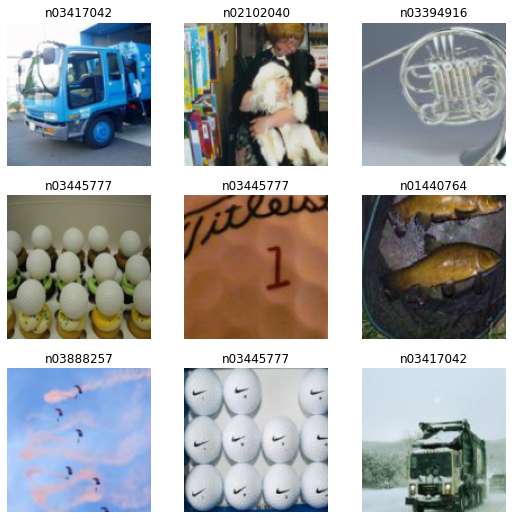

In [10]:
dls.show_batch()  # TfmdDL.show_batch() defaults to showing one batch
                  # of pipeline outputs.

In [13]:
fnames = get_image_files(path)

# DataBlock fundamentals

In [14]:
# This gives us an empty datablock (a recipe of what to do to data).
#   - You have to first pass it a source
#   - You can then convert it to a Datasets using dblock.datasets() or
#     to a DataLoaders using dblock.dataloaders().
#     The dblock.dataloaders() requires us to get the data ready for batches.
#     Here we don't have that, so we use datasets.
dblock = DataBlock()  # Recursively gets all image files from subfolders.
                      # If folders variable is set, it only looks in those folders.

In [17]:
dsets = dblock.datasets(fnames)
dsets.train[0]  # The datablock API assumes we have an input and a target.
                # This is why our filename is repeated twice.

(Path('/root/.fastai/data/imagenette2-160/val/n03888257/n03888257_32520.JPEG'),
 Path('/root/.fastai/data/imagenette2-160/val/n03888257/n03888257_32520.JPEG'))

In [19]:
# Instead, let us build a datablock with the get_items function set so it
# knows how to get the data.
dblock = DataBlock(get_items = get_image_files)

In [20]:
dsets = dblock.datasets(path)
dsets.train[0]

(Path('/root/.fastai/data/imagenette2-160/val/n03394916/n03394916_42312.JPEG'),
 Path('/root/.fastai/data/imagenette2-160/val/n03394916/n03394916_42312.JPEG'))

In [24]:
# To convert our target to a label, use parent_label on the filename.
# But the output label is not very readable.
parent_label(fnames[0])

'n03394916'

In [25]:
# Instead, use this label mapping.
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [26]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [27]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func) # Func that converts filename to label

dsets = dblock.datasets(path)
dsets.train[0]

(Path('/root/.fastai/data/imagenette2-160/train/n03028079/n03028079_5983.JPEG'),
 'church')

In [33]:
# Tell the data block the types of our inputs/oututs.
# If you have more than one inputs/targets, 
# specify n_inp (number of inputs). The rest are targets.
# You also need to pass a list of functions to get_x/get_y
# to tell data block how to process each input/target.
dblock = DataBlock(blocks    = (ImageBlock,     # Inputs are images
                                CategoryBlock), # Outputs are categories
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter = GrandparentSplitter(),  # Train/Validation split using the Grandparent folder

                   # The item transforms and batch transforms are the same way
                   # as we do in the ImageDataLoaders factory methods.
                   item_tfms = RandomResizedCrop(128, min_scale=0.35), 
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                   )

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=240x160, TensorCategory(1))

In [34]:
# The datablock API created a mapping from categories to index, called a vocab.
dsets.vocab

(#10) ['English springer','French horn','cassette player','chain saw','church','garbage truck','gas pump','golf ball','parachute','tench']

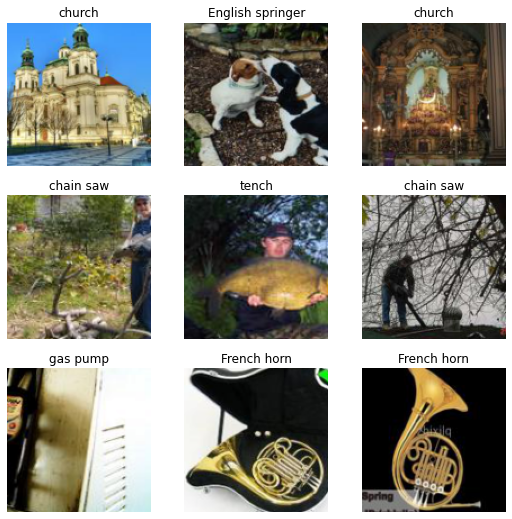

In [35]:
# Batch items together and convert to dataloaders using the dataloaders() function.
dls = dblock.dataloaders(path)
dls.show_batch()

In [36]:
# Another way to compose the target using several functions is by using a pipeline
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize.from_stats(*imagenet_stats))

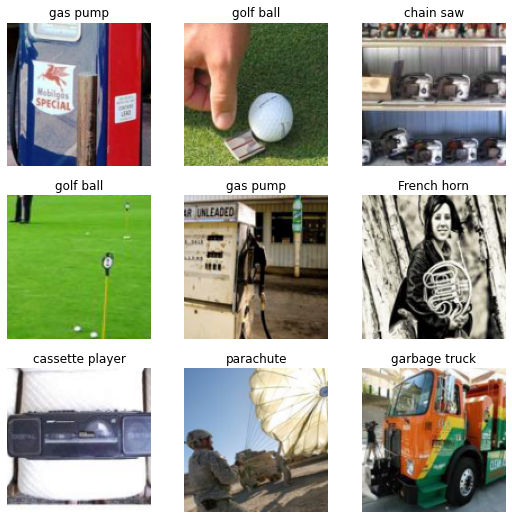

In [37]:
dls = imagenette.dataloaders(path)
dls.show_batch()

To learn more about the data block API: https://docs.fast.ai/tutorial.datablock

# Loading the data with the mid-level API (Transform, Datasets)

In [38]:
source = untar_data(URLs.IMAGENETTE_160)
fnames = get_image_files(source)

In [39]:
# Transformations applied to the filenames (here they are filenames),
# can be different if the type of the item given to the function
# is different. This is called type dispatch.
# Transformations are applied on each element of a tuple. ex:
#   (image, label) -> resize transform -> (resize(image), label)  # no resize on label
#                                                                 # since you cannot resize label
#   (image, mask)  -> resize transform -> (resize(image), resize(mask))
#
# A transform can have:
#   - A setup executed on the whole set (or whole training set). This is how
#     Categorize builds it's vocabulary automatically
#   - A decodes that undoes what the transform does for showing purposes (ex.
#     Categorize will convert an index back into a category)

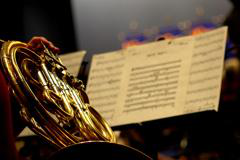

In [40]:
PILImage.create(fnames[0])

In [41]:
fnames[0]

Path('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_12266.JPEG')

In [42]:
lbl_dict[parent_label(fnames[0])]  # n03394916 -> 'French horn'

'French horn'

In [44]:
tfm = Pipeline([parent_label,                     # Get the parent labels.
                lbl_dict.__getitem__,             # 
                Categorize(                       # Categorize to create labels.
                    vocab = lbl_dict.values()     # Pass in the labels explicitly.
                    )]
               )
tfm(fnames[0])

TensorCategory(1)

In [43]:
doc(Pipeline)